In [5]:
import numpy as np
X_train=np.zeros((5465,150,150,3))
y_train=np.zeros((5465,1))
y_train[:2778,0]=1

X_test=np.zeros((400,150,150,3))
y_test=np.zeros((400,1))
y_test[:188,0]=1

In [6]:
import glob
from keras.preprocessing.image import load_img,img_to_array

input_folder="./augmented_data/train/"
i=0
for img in glob.glob(input_folder+"/mask/*.jpg"):
    image=load_img(img)
    image=img_to_array(image)
    X_train[i,:,:]=image/255
    i+=1
for img in glob.glob(input_folder+"/nomask/*.jpg"):
    image=load_img(img)
    image=img_to_array(image)
    X_train[i,:,:]=image/255
    i+=1
    

In [9]:
i

5465

In [10]:
input_folder="./augmented_data/test/"
i=0
for img in glob.glob(input_folder+"/mask/*.jpg"):
    image=load_img(img)
    image=img_to_array(image)
    X_test[i,:,:]=image/255
    i+=1
for img in glob.glob(input_folder+"/nomask/*.jpg"):
    image=load_img(img)
    image=img_to_array(image)
    X_test[i,:,:]=image/255
    i+=1

In [12]:
X_test.shape[0]

400

In [17]:
def shuffle_set(X,y):
    size=X.shape[0]
    idx=np.arange(size)
    
    rdn_gen=np.random.default_rng(seed=51)
    rdn_gen.shuffle(idx)
    
    X_shuffle=X[idx,:,:]
    y_shuffe=y[idx,:]
    
    return X_shuffle,y_shuffe

In [18]:
X_train_shuffle,y_train_shuffle=shuffle_set(X_train,y_train)

In [19]:
X_test_shuffle,y_test_shuffle=shuffle_set(X_test,y_test)

In [20]:
from keras.applications import vgg16
from keras.models import Model
import keras
vgg=vgg16.VGG16(include_top=False,weights='imagenet',input_shape=(150,150,3))

In [21]:
for layer in vgg.layers[:]:
    layer.trainable=False

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [23]:
from keras.models import Sequential
transfer_model=Sequential()

In [24]:
from keras.layers import Flatten,Dense,Dropout

In [25]:
transfer_model.add(vgg)

transfer_model.add(Flatten())

transfer_model.add(Dense(1024,activation='relu'))
transfer_model.add(Dropout(rate=0.25))

transfer_model.add(Dense(128,activation='relu'))
transfer_model.add(Dropout(rate=0.25))

transfer_model.add(Dense(1,activation='sigmoid'))

In [26]:
print(transfer_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              8389632   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [27]:
transfer_model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [28]:
transfer_model.fit(x=X_train_shuffle,y=y_train_shuffle,batch_size=64,epochs=30)

Epoch 1/30
5465/5465 [==============================] - 259s 47ms/step - loss: 1.0859 - accuracy: 0.8942
Epoch 2/30
5465/5465 [==============================] - 258s 47ms/step - loss: 0.1328 - accuracy: 0.9548
Epoch 3/30
5465/5465 [==============================] - 258s 47ms/step - loss: 0.0612 - accuracy: 0.9784
Epoch 4/30
5465/5465 [==============================] - 250s 46ms/step - loss: 0.0362 - accuracy: 0.9861
Epoch 5/30
5465/5465 [==============================] - 260s 48ms/step - loss: 0.0233 - accuracy: 0.9932
Epoch 6/30
5465/5465 [==============================] - 250s 46ms/step - loss: 0.0169 - accuracy: 0.9945
Epoch 7/30
5465/5465 [==============================] - 250s 46ms/step - loss: 0.0145 - accuracy: 0.9956
Epoch 8/30
5465/5465 [==============================] - 254s 46ms/step - loss: 0.0078 - accuracy: 0.9960
Epoch 9/30
5465/5465 [==============================] - 251s 46ms/step - loss: 0.0194 - accuracy: 0.9960
Epoch 10/30
5465/5465 [==============================] 

KeyboardInterrupt: 

In [29]:
transfer_model.evaluate(x=X_test_shuffle,y=y_test_shuffle)

400/400 [==============================] - 19s 46ms/step


[0.36516795873641966, 0.9975000023841858]

In [62]:
transfer_model.save("transfer_model")

Cargar modelo

In [66]:
transfer_model=keras.models.load_model("transfer_model")

In [48]:
from matplotlib import pyplot as plt
import cv2
def load_my_img(name):
    my_img=load_img("./img_pruebas/"+name+".jpg")
    my_img=img_to_array(my_img)/255
    my_img=cv2.resize(my_img,(150,150))
    plt.imshow(my_img)
    my_img=np.reshape(my_img,[1,150,150,3])
    return my_img

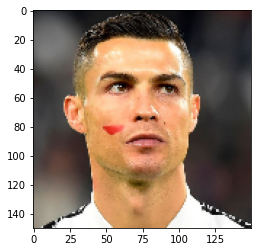

In [50]:
cr7=load_my_img("cr7")

In [51]:
transfer_model.predict(cr7)

array([[0.234538]], dtype=float32)

array([[0.45315948]], dtype=float32)

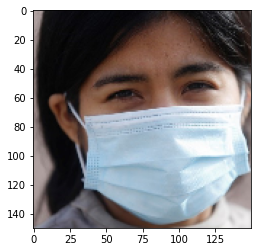

In [52]:
senora=load_my_img("maskgirl")
transfer_model.predict(senora)

array([[0.6280056]], dtype=float32)

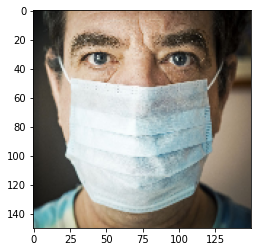

In [55]:
prueba=load_my_img("manmask")
transfer_model.predict(prueba)

In [44]:
transfer_model.predict_proba(my_img)

array([[0.64994276]], dtype=float32)

array([[0.64994276]], dtype=float32)

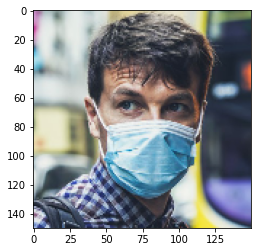

In [56]:
man=load_my_img("mask")
transfer_model.predict(man)

array([[0.45510662]], dtype=float32)

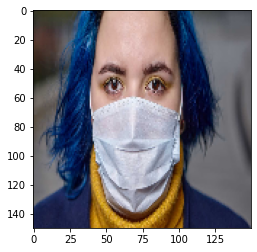

In [57]:
man=load_my_img("download")
transfer_model.predict(man)

array([[0.45223236]], dtype=float32)

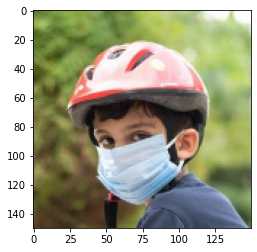

In [59]:
man=load_my_img("nino")
transfer_model.predict(man)

array([[0.4227845]], dtype=float32)

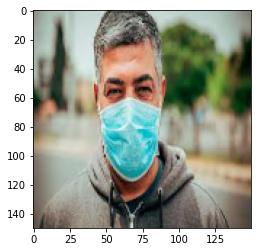

In [61]:
man=load_my_img("0101")
transfer_model.predict_proba(man)